<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Part 2: Data Science Tools for Medical Deep Learning

While we have already trained a neural network, here we are focused on creating and validating an augmented dataset. We know that the neural network from the previous section, when trained, is able to produce 98.3-99.6% accuracy on MedNIST. <b>Therefore, if our augmentation techniques are robust, we should be able to see a comparable accuracy when trained on an augmented set.</b>

If all we could do with augmentation was reproduce the accuracy of some original set, what would be the point? However, suppose we had a small dataset that was similar in type to MedNIST. Because we validated the accuracy of our augmentation process on MedNIST, we could apply the same techniques to these similar images and have good confidence that the augmented set would be robust. <b>Thus, the general workflow for this type of validation is to develop an augmentation process on a large dataset, then move to a smaller dataset with similar structure, and use it there to generate new data where no additional "ground truth" values are available.</b>

You will be guided through a basic series of exercises to normalize and augment an imaging dataset. While these steps will not apply to every task, this process is similar to what you might use to prepare your data. At the end, you will be able to download the augmented dataset you have created for use in your own deep learning projects.

We start by importing our libraries and reloading the data for this notebook.

In [43]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

# confusion matrix plotting
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

If you want to remove an augmented dataset that was created in a previous run and start from scratch, uncomment and execute the below cell.

In [44]:
## Run this if you want to remove augmented data
# !rm -r data/resized
# !cp -r data/resizedbackup data/resized

In [45]:
dataDir = 'data/resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 90000 images in 6 distinct categories
Label names: ['CXR', 'ChestCT', 'Hand', 'BreastMRI', 'HeadCT', 'AbdomenCT']
Label counts: [15000, 15000, 15000, 15000, 15000, 15000]
Image dimensions: 64 x 64


## Data Augmentation

We will explore data augmentation techniques to normalize the number of images in each category, but first, we take a look at some of the images available. The code block below can be run multiple times to sample different images.

### Code Block 1

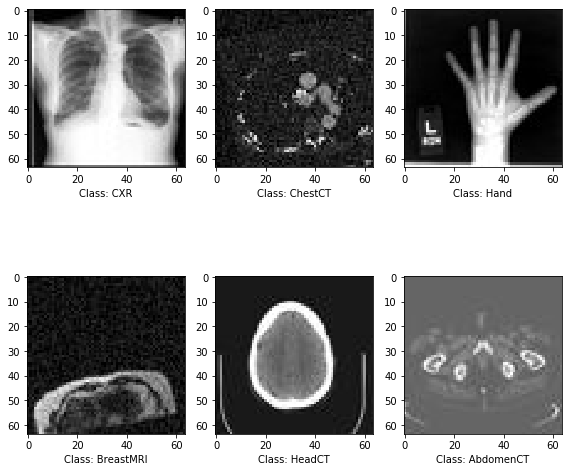

In [46]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass): 
    im = Image.open(imageFiles[i][np.random.randint(numEach[i])])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel('Class: '+classNames[i])
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

Note that some of the images are scaled differently than others - that is, they have different maximum and minimum brightness. Before performing the final set of augmentations, we will standardize the brightness of the images.

However, let's explore how some different transformations look without this rescaling procedure. We start with `RandomRotation`, which, as the name suggests, rotates the image by a random number of degrees up to some maximum value in either direction. The unrotated image appears in the upper left corner.

#### Exercise:
Rerun the code block below multiple times, trying different maximum rotation values (change the value of `maxRot`). 

### Code Block 2

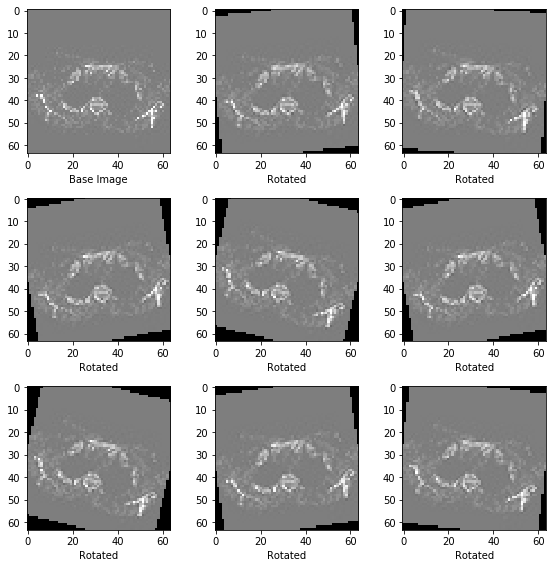

In [47]:
maxRot = 15
randRot = tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randRot(baseImage)
    # tv.transforms.RandomRotation(maxRot,resample=Image.BICUBIC)(baseImage)
    mp.subplot(3,3,i+2)
    mp.xlabel('Rotated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

We can also try random translations. These are performed with the `RandomAffine` transformation function, which includes a more general class of transformations (rotations, translations, shear, rescaling), but with the rest of the options turned off.

The translations are performed as a fraction (0-1) of the entire image size. The x and y translations can be set to different values.

#### Exercise:
Rerun the code block below with several different values of `maxTrX` and/or `maxTrY`

### Code Block 3

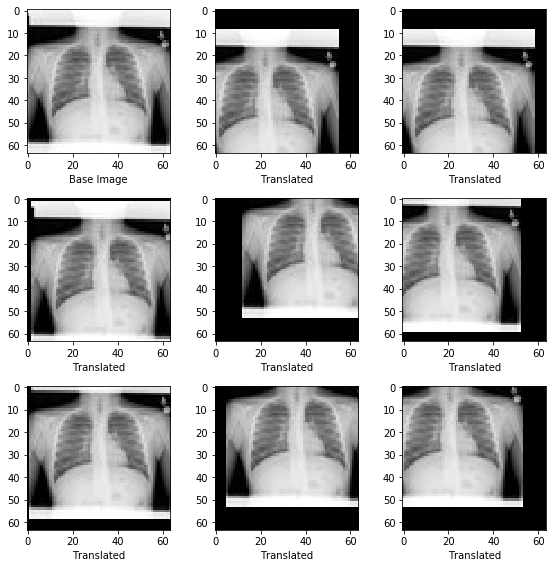

In [48]:
maxTrX = 0.2
maxTrY = 0.2
randTr = tv.transforms.RandomAffine(0,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    randImage = randTr(baseImage)
    arr = np.array(im)
    mp.subplot(3,3,i+2)
    mp.xlabel('Translated')
    mp.imshow(np.array(randImage),cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

We next try adding random noise to the images. While the code below produces white noise, in real applications we could produce noise functions that better model specific imaging modalities.

#### Exercise:
Rerun the code block with different values of `noiseStrength`. A value of 0.5 means that the noise will be weighted equally to the image.

### Code Block 4

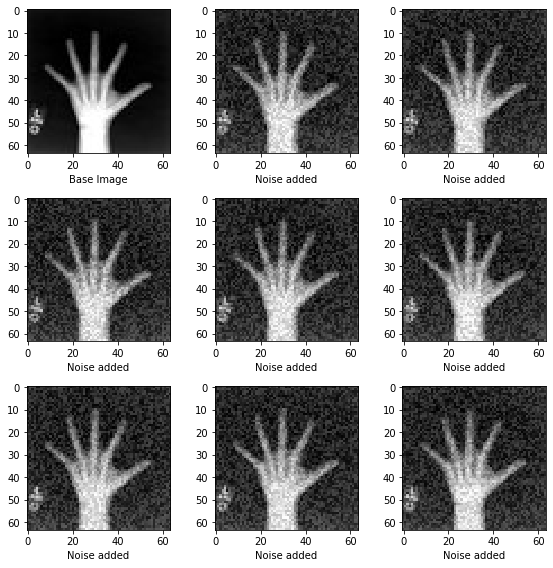

In [49]:
noiseStrength = 0.25
baseImage = Image.open(imageFiles[np.random.randint(6)][np.random.randint(8000)])
mp.subplots(3,3,figsize=(8,8))
mp.subplot(3,3,1)
mp.xlabel('Base Image')
mp.imshow(np.array(baseImage),cmap='gray',vmin=0,vmax=255)
for i in range(8):
    noise = np.random.random((imageWidth,imageHeight))
    arr = np.array(baseImage)*(1-noiseStrength)+255*noiseStrength*noise
    mp.subplot(3,3,i+2)
    mp.xlabel('Noise added')
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

Based on your previous experiments, choose values for the parameters `maxRot`, `maxTrX`, `maxTrY`, and `noiseStrength` that will add some variability to the images without altering them unrecognizably. The code block below will augment each class of image using the combined transformations on randomly chosen source images until the target number of 15000 of each class is reached.

#### NOTE!
This code should only be run once, as it will create image files to augment the dataset. Use the code blocks above to try different parameter values before setting them below and executing the code. You can run the `rm` and `cp` commands again if you want to try again.

We define one final scaling function before we combine all these transformations and use them to augment the dataset.

### Code Block 5

In [50]:
## Run this if you want to remove augmented data
# !rm -r data/resized
# !cp -r data/resizedbackup data/resized

In [51]:
def normalizeImage(x):
    y = np.array(x)
    if(np.min(y) < np.max(y)):  # Assuming the image isn't empty, rescale so its values run from 0 to 255
        y = 255.0*(y - 1.0*np.min(y))/(1.0*np.max(y) - np.min(y))
    z = Image.fromarray(np.uint8(y))
    return z

In [52]:
numPerClass = 15000
maxRot = 30
maxTrX = 0.2
maxTrY = 0.2
noiseStrength = 0.15
randAff = tv.transforms.RandomAffine(maxRot,translate=(maxTrX,maxTrY),resample=Image.BICUBIC)

for i in range(numClass):
    print('Augmenting class',classNames[i])
    for j in range(numPerClass - numEach[i]):
        if j % 2000 == 0:
            print('Adding image number',j)
        imageID = np.random.randint(numEach[i])
        baseImage = Image.open(imageFiles[i][imageID])
        randImage = randAff(normalizeImage(baseImage))
        noise = np.random.random((imageWidth,imageHeight))
        arr = np.array(randImage)*(1-noiseStrength)+255*noiseStrength*noise
        finalImage = Image.fromarray(np.uint8(arr))
        fname = imageFiles[i][imageID][:-5]+str(j)+'a.jpeg'
        finalImage.save(fname)

Augmenting class CXR
Augmenting class ChestCT
Augmenting class Hand
Augmenting class BreastMRI
Augmenting class HeadCT
Augmenting class AbdomenCT


Let's double check that the expected files were created by counting the number of images in each class now.

### Code Block 6

In [53]:
imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                       # list of all files
numEachAug = [len(imageFilesAug[i]) for i in range(numClass)]       # Count of each image class

for i in range(numClass):
    print("Category",classNames[i],"has",numEachAug[i],"images")

Category CXR has 15000 images
Category ChestCT has 15000 images
Category Hand has 15000 images
Category BreastMRI has 15000 images
Category HeadCT has 15000 images
Category AbdomenCT has 15000 images


Run the code below several times to see example outputs of augmented data.

### Code Block 7

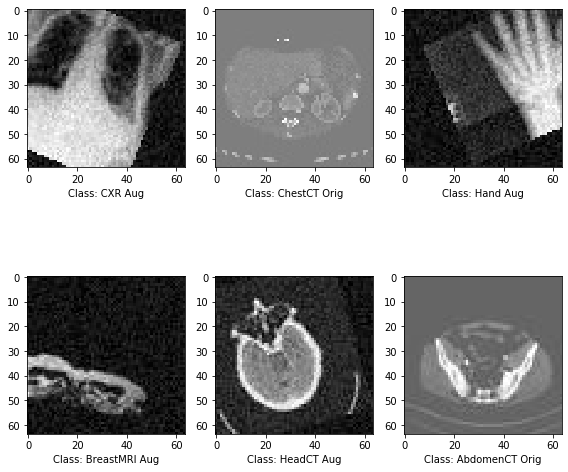

In [54]:
mp.subplots(3,2,figsize=(8,8))
for i in range(numClass):
    imageID = np.random.randint(numEachAug[i])
    im = Image.open(imageFilesAug[i][imageID])   # Randomly sample one image per class
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    if imageFilesAug[i][imageID][-6] == 'a':
        imageType = ' Aug'
    else:
        imageType = ' Orig'
    mp.xlabel('Class: '+classNames[i]+imageType)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

In the below cells, we will create a new dataset with the augmented data in conjunction with the original data, create a master tensor, and then slice this into training, validation, and testing sets.

### Code Block 8

In [55]:
toTensor = tv.transforms.ToTensor()
def scaleImage(x):          # Pass a PIL image, return a tensor
    y = toTensor(x)
    if(y.min() < y.max()):  # Assuming the image isn't empty, rescale so its values run from 0 to 1
        y = (y - y.min())/(y.max() - y.min()) 
    z = y - y.mean()        # Subtract the mean value of the image
    return z

In [56]:
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list

imageFilesAug = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]
for i in range(numClass):
    imageFilesList.extend(imageFilesAug[i])
    imageClass.extend([i]*numEachAug[i])
numTotalAug = np.sum(numEachAug)

# Rescale augmented dataset and create tensors
imageTensor = torch.stack([scaleImage(Image.open(x)) for x in imageFilesList])  # Load, scale, and stack image (X) tensor
classTensor = torch.tensor(imageClass)  # Create label (Y) tensor
print("Rescaled min pixel value = {:1.3}; Max = {:1.3}; Mean = {:1.3}"
      .format(imageTensor.min().item(),imageTensor.max().item(),imageTensor.mean().item()))

Rescaled min pixel value = -0.786; Max = 0.972; Mean = -7.64e-07


### Code Block 9

In [57]:
validFrac = 0.1   # Define the fraction of images to move to validation dataset
testFrac = 0.1    # Define the fraction of images to move to test dataset
validList = []
testList = []
trainList = []
trainX = []

for i in range(numTotalAug):
    rann = np.random.random() # Randomly reassign images
    if rann < validFrac:
        validList.append(i)
    elif rann < testFrac + validFrac:
        testList.append(i)
    else:
        trainList.append(i)
        
nTrainAug = len(trainList)  # Count the number in each set
nValidAug = len(validList)
nTestAug = len(testList)
print("Training images =",nTrainAug,"Validation =",nValidAug,"Testing =",nTestAug)

trainIds = torch.tensor(trainList)    # Slice the big image and label tensors up into
validIds = torch.tensor(validList)    #       training, validation, and testing tensors
testIds = torch.tensor(testList)
trainX = imageTensor[trainIds,:,:,:]
trainY = classTensor[trainIds]
validX = imageTensor[validIds,:,:,:]
validY = classTensor[validIds]
testX = imageTensor[testIds,:,:,:]
testY = classTensor[testIds]

Training images = 72135 Validation = 8970 Testing = 8895


We must redefine the MedNet architecture since we are in a new Python notebook.

### Code Block 10

In [58]:
class MedNet(nn.Module):
    def __init__(self,xDim,yDim,numC): # Pass image dimensions and number of labels when initializing a model   
        super(MedNet,self).__init__()  # Extends the basic nn.Module to the MedNet class
        # The parameters here define the architecture of the convolutional portion of the CNN. Each image pixel
        # has numConvs convolutions applied to it, and convSize is the number of surrounding pixels included
        # in each convolution. Lastly, the numNodesToFC formula calculates the final, remaining nodes at the last
        # level of convolutions so that this can be "flattened" and fed into the fully connected layers subsequently.
        # Each convolution makes the image a little smaller (convolutions do not, by default, "hang over" the edges
        # of the image), and this makes the effective image dimension decreases.
        
        numConvs1 = 5
        convSize1 = 7
        numConvs2 = 10
        convSize2 = 7
        numNodesToFC = numConvs2*(xDim-(convSize1-1)-(convSize2-1))*(yDim-(convSize1-1)-(convSize2-1))

        # nn.Conv2d(channels in, channels out, convolution height/width)
        # 1 channel -- grayscale -- feeds into the first convolution. The same number output from one layer must be
        # fed into the next. These variables actually store the weights between layers for the model.
        
        self.cnv1 = nn.Conv2d(1, numConvs1, convSize1)
        self.cnv2 = nn.Conv2d(numConvs1, numConvs2, convSize2)

        # These parameters define the number of output nodes of each fully connected layer.
        # Each layer must output the same number of nodes as the next layer begins with.
        # The final layer must have output nodes equal to the number of labels used.
        
        fcSize1 = 400
        fcSize2 = 80
        
        # nn.Linear(nodes in, nodes out)
        # Stores the weights between the fully connected layers
        
        self.ful1 = nn.Linear(numNodesToFC,fcSize1)
        self.ful2 = nn.Linear(fcSize1, fcSize2)
        self.ful3 = nn.Linear(fcSize2,numC)
        
    def forward(self,x):
        # This defines the steps used in the computation of output from input.
        # It makes uses of the weights defined in the __init__ method.
        # Each assignment of x here is the result of feeding the input up through one layer.
        # Here we use the activation function elu, which is a smoother version of the popular relu function.
        
        x = F.elu(self.cnv1(x)) # Feed through first convolutional layer, then apply activation
        x = F.elu(self.cnv2(x)) # Feed through second convolutional layer, apply activation
        x = x.view(-1,self.num_flat_features(x)) # Flatten convolutional layer into fully connected layer
        x = F.elu(self.ful1(x)) # Feed through first fully connected layer, apply activation
        x = F.elu(self.ful2(x)) # Feed through second FC layer, apply output
        x = self.ful3(x)        # Final FC layer to output. No activation, because it's used to calculate loss
        return x

    def num_flat_features(self, x):  # Count the individual nodes in a layer
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Finally, we instantiate a new model and train it on our new dataset.

In [59]:
model_aug = MedNet(imageWidth,imageHeight,numClass).to(dev)

In [60]:
learnRate = 0.01          # Define a learning rate.
maxEpochs = 20            # Maximum training epochs
t2vRatio = 1.2            # Maximum allowed ratio of validation to training loss
t2vEpochs = 3             # Number of consecutive epochs before halting if validation loss exceeds above limit
batchSize = 300           # Batch size. Going too large will cause an out-of-memory error.
trainBats = nTrainAug // batchSize       # Number of training batches per epoch. Round down to simplify last batch
validBats = nValidAug // batchSize       # Validation batches. Round down
testBats = -(-nTestAug // batchSize)     # Testing batches. Round up to include all
CEweights = torch.zeros(numClass)     # This takes into account the imbalanced dataset.
for i in trainY.tolist():             #      By making rarer images count more to the loss, 
    CEweights[i].add_(1)              #      we prevent the model from ignoring them.
CEweights = 1. / CEweights.clamp_(min=1.)                     # Weights should be inversely related to count
CEweights = (CEweights * numClass / CEweights.sum()).to(dev)  # The weights average to 1
opti = om.SGD(model_aug.parameters(), lr = learnRate)   # Initialize an optimizer


for i in range(maxEpochs):
    model_aug.train()                     # Set model to training mode
    epochLoss = 0.
    permute = torch.randperm(nTrainAug)  # Shuffle data to randomize batches
    trainX = trainX[permute,:,:,:]
    trainY = trainY[permute]
    for j in range(trainBats):        # Iterate over batches
        opti.zero_grad()              # Zero out gradient accumulated in optimizer
        batX = trainX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)   # Slice shuffled data into batches
        batY = trainY[j*batchSize:(j+1)*batchSize].to(dev)         # .to(dev) moves these batches to the GPU
        yOut = model_aug(batX)            # Evalute predictions
        loss = F.cross_entropy(yOut, batY, weight=CEweights)        # Compute loss
        epochLoss += loss.item()      # Add loss
        loss.backward()               # Backpropagate loss
        opti.step()                   # Update model weights using optimizer
    validLoss = 0.
    permute = torch.randperm(nValidAug)  # We go through the exact same steps, without backprop / optimization
    validX = validX[permute,:,:,:]    # in order to evaluate the validation loss
    validY = validY[permute]
    model_aug.eval()                      # Set model to evaluation mode
    with torch.no_grad():             # Temporarily turn off gradient descent
        for j in range(validBats):
            opti.zero_grad()
            batX = validX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
            batY = validY[j*batchSize:(j+1)*batchSize].to(dev)
            yOut = model_aug(batX)
            validLoss += F.cross_entropy(yOut, batY, weight=CEweights).item()
    epochLoss /= trainBats            # Average loss over batches and print
    validLoss /= validBats
    print("Epoch = {:-3}; Training loss = {:.4f}; Validation loss = {:.4f}".format(i,epochLoss,validLoss))
    if validLoss > t2vRatio * epochLoss:
        t2vEpochs -= 1                # Test if validation loss exceeds halting threshold
        if t2vEpochs < 1:
            print("Validation loss too high; halting to prevent overfitting")
            break

Epoch =   0; Training loss = 0.8189; Validation loss = 0.3654
Epoch =   1; Training loss = 0.2407; Validation loss = 0.1904
Epoch =   2; Training loss = 0.1489; Validation loss = 0.1418
Epoch =   3; Training loss = 0.1208; Validation loss = 0.1181
Epoch =   4; Training loss = 0.1016; Validation loss = 0.0997
Epoch =   5; Training loss = 0.1213; Validation loss = 0.1001
Epoch =   6; Training loss = 0.0811; Validation loss = 0.0857
Epoch =   7; Training loss = 0.0702; Validation loss = 0.0746
Epoch =   8; Training loss = 0.0616; Validation loss = 0.0697
Epoch =   9; Training loss = 0.0536; Validation loss = 0.0718
Epoch =  10; Training loss = 0.0485; Validation loss = 0.0536
Epoch =  11; Training loss = 0.0429; Validation loss = 0.0480
Epoch =  12; Training loss = 0.0384; Validation loss = 0.0473
Epoch =  13; Training loss = 0.0339; Validation loss = 0.0423
Validation loss too high; halting to prevent overfitting


## Validation and Comparison of Models

Let's generate a new confusion matrix and compare it to the previous model.

### Code Block 11

Augmented Accuracy =  0.9866216975829117


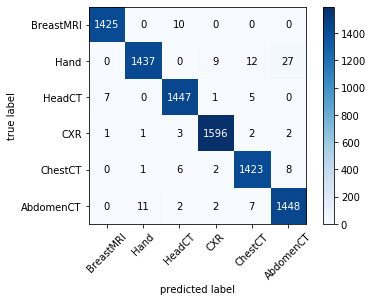

In [61]:
model_aug.eval()
with torch.no_grad():
    permute = torch.randperm(nTestAug)                     # Shuffle test data
    testX = testX[permute,:,:,:]
    testY = testY[permute]
    pred_aug = []

    for j in range(testBats):                           # Iterate over test batches
        batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
        batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
        yOut = model_aug(batX)                              # Pass test batch through model
        predict = yOut.max(1)[1].cpu().numpy()
        pred_aug = np.concatenate((pred_aug, predict))

# Augmented confusion matrix
class_names = ['BreastMRI', 'Hand', 'HeadCT', 'CXR', 'ChestCT', 'AbdomenCT']
print("Augmented Accuracy = ", accuracy_score(pred_aug, testY))
cm_aug = confusion_matrix(pred_aug, testY)
_ = plot_confusion_matrix(cm_aug, colorbar=True, class_names=class_names)

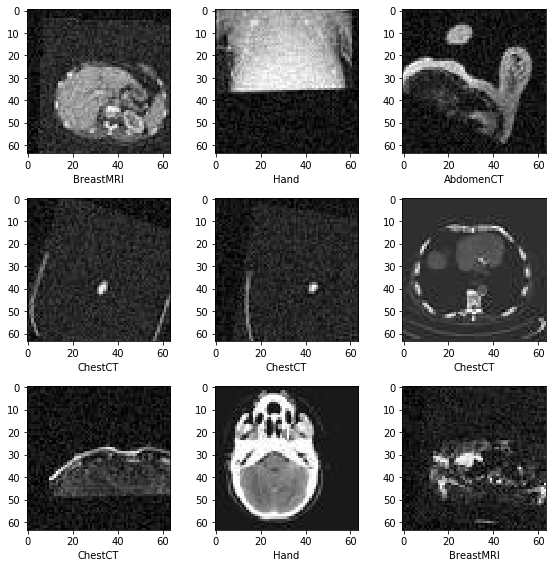

In [62]:
def scaleBack(x):               # Pass a tensor, return a numpy array from 0 to 1
    if(x.min() < x.max()):      # Assuming the image isn't empty, rescale so its values run from 0 to 1
        x = (x - x.min())/(x.max() - x.min())
    return x[0].to(cpu).numpy() # Remove channel (grayscale anyway)

model_aug.eval()
mp.subplots(3,3,figsize=(8,8))
imagesLeft = 9
permute = torch.randperm(len(testList))        # Shuffle test data
testX = testX[permute,:,:,:]
testY = testY[permute]
for j in range(testBats):              # Iterate over test batches
    batX = testX[j*batchSize:(j+1)*batchSize,:,:,:].to(dev)
    batY = testY[j*batchSize:(j+1)*batchSize].to(dev)
    yOut = model_aug(batX)                 # Pass test batch through model
    pred = yOut.max(1)[1].tolist()     # Generate predictions by finding the max Y values
    for i, y in enumerate(batY.tolist()):
        if imagesLeft and y != pred[i]:         # Compare the actual y value to the prediction
            imagesLeft -= 1
            mp.subplot(3,3,9-imagesLeft)
            mp.xlabel(classNames[pred[i]])      # Label image with what the model thinks it is
            mp.imshow(scaleBack(batX[i]),cmap='gray',vmin=0,vmax=1)
mp.tight_layout()
mp.show()

## Conclusion

You should see accuracy above 98%+. You may notice that the accuracy is slightly worse than the original dataset. Remember we are aiming for <b>comparable</b> accuracy, not identical. As long as we are in the same performance range, we can be fairly sure that we are not introducing any deformations into the training set that will hurt our generalization capability. Since every dataset is different in terms of size, objective, and class distribution, there is not one single method or set of parameters that we can use to guarantee increased performance. Rather, we should verify experimental techniques such as the augmentations  performed above in settings where they can be validated, and then translate them to smaller sets as a starting point.

Feel free to continue to play with the augmentations parameters, re-creating the dataset and retraining the network several times. You can also go back to the confusion matrix in the previous notebook to compare results. 

Good luck!

<img src="images/DLI Header.png" alt="Header" style="width: 400px;"/>